In [9]:
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45
from torchdyn.numerics import odeint
from torchdyn.core import ODEProblem

import torchdiffeq
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
class VanDerPol(nn.Module):
    def __init__(self, alpha=10):
        super().__init__()
        self.alpha = alpha
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        x1, x2 = x[...,:1], x[...,1:2]
        return torch.cat([x2, self.alpha * (1 - x1**2) * x2 - x1], -1)

In [11]:
f = VanDerPol()
x = torch.randn(1024, 2)
t_span = torch.linspace(0, 3, 300)

#### Fixed--step bench

In [12]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='rk4')
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='rk4')
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.0637514591217041
0.06930422782897949


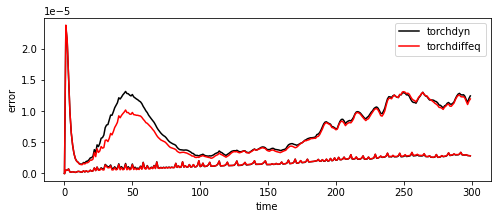

In [13]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

#### Adaptive-step bench

In [70]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='dopri5', interpolator='4th', atol=1e-4, rtol=1e-4)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-4, rtol=1e-4)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.18353033065795898
0.032141685485839844


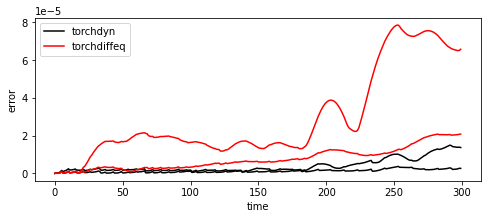

In [71]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).detach().abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).detach().abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

### Using `ODEProblem`

In [126]:
from torchdyn.core import ODEProblem

f = VanDerPol(0.5)
t_span = torch.linspace(0, 2, 300)
x = torch.randn(1024, 2, requires_grad=True)

##### Backsolve Adjoint

* We are slower when the ODE is easy to solve due to the checkpointing strategy used that slows down `dt`

In [127]:
prob = ODEProblem(f, sensitivity='adjoint', solver='tsit5', atol=1e-3, rtol=1e-3, atol_adjoint=1e-3, rtol_adjoint=1e-3)
t0 = time.time()
t_eval, sol_torchdyn = prob.odeint(x, t_span)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol_torchdiffeq = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-3, rtol=1e-3)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

Your vector field does not have `nn.Parameters` to optimize.
0.17838144302368164
0.018263816833496094


In [128]:
t0 = time.time()
grad1 = torch.autograd.grad(sol_torchdyn[-1].sum(), x)[0]
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
grad2 = torch.autograd.grad(sol_torchdiffeq[-1].sum(), x)[0]
t_end2 = time.time() - t0
print(t_end2)

grad_true = torch.autograd.grad(true_sol[-1].sum(), x)[0]

0.6487090587615967
0.8733053207397461


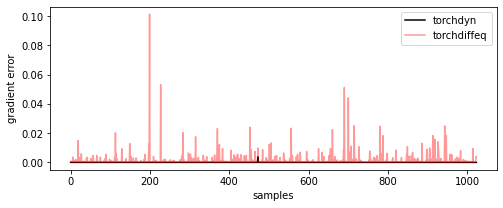

In [131]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot((grad1-grad_true).abs().sum(1), c='black')
ax.plot((grad2-grad_true).abs().sum(1), c='red', alpha=0.4)
ax.set_ylabel('gradient error')
ax.set_xlabel('samples')
plt.legend(['torchdyn', 'torchdiffeq'])

##### Interpolated Adjoint

In [51]:
t0 = time.time()
prob = ODEProblem(f, sensitivity='interpolated_adjoint', interpolator='4th', solver='dopri5', atol=1e-4, rtol=1e-4)
t_eval, sol_torchdyn = prob.odeint(x, t_span)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol_torchdiffeq = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-4, rtol=1e-4)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.03173661231994629
0.019273042678833008


In [52]:
t0 = time.time()
grad1 = torch.autograd.grad(sol_torchdyn[-1].sum(), x)[0]
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
grad2 = torch.autograd.grad(sol_torchdiffeq[-1].sum(), x)[0]
t_end2 = time.time() - t0
print(t_end2)

grad_true = torch.autograd.grad(true_sol[-1].sum(), x)[0]

0.8546793460845947
0.844252347946167


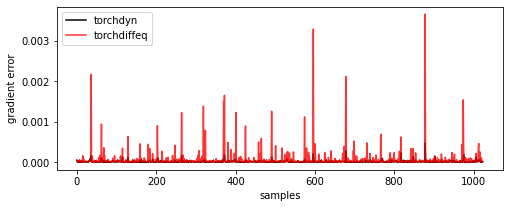

In [53]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot((grad1-grad_true).abs().sum(1), c='black')
ax.plot((grad2-grad_true).abs().sum(1), c='red', alpha=0.8)
ax.set_ylabel('gradient error')
ax.set_xlabel('samples')
plt.legend(['torchdyn', 'torchdiffeq'])

#### Integral loss (backsolve)

In [302]:
t_span = torch.linspace(0, 2, 500)

In [303]:
from torchdyn.core import NeuralODE

def reg_term(t, x):
    return 0.1*x[:,:1]

x = torch.randn(1024, 2, requires_grad=True)

# solve with autograd augmentation
node = NeuralODE(f, sensitivity='autograd', solver='rk4', interpolator='4th', 
                  atol=1e-4, rtol=1e-4, integral_loss=reg_term)
x0 = torch.cat([torch.zeros(x.shape[0], 1), x], 1)

t_eval, sol_torchdyn = node(x0, t_span)
loss = sol_torchdyn[-1,:,0].sum()
loss.backward()
grad_autograd = x.grad
x.grad = 0*x.grad

# solve with integral loss without aug
node = NeuralODE(f, sensitivity='adjoint', solver='dopri5', interpolator='4th', 
                  atol=1e-4, rtol=1e-4, atol_adjoint=1e-5, rtol_adjoint=1e-5, integral_loss=reg_term)

t_eval, sol_torchdyn = node(x, t_span)
(0.*sol_torchdyn[-1].sum()).backward()
grad_adj = x.grad

(grad_autograd-grad_adj).abs().mean()

tensor(8.4026e-06)

In [304]:
from torchdyn.core import NeuralODE

def reg_term(t, x):
    return x.sum(1, keepdim=True)

x = torch.randn(1024, 2, requires_grad=True)

# solve with autograd augmentation
node = NeuralODE(f, sensitivity='autograd', solver='rk4', interpolator='4th', 
                  atol=1e-4, rtol=1e-4, integral_loss=reg_term)
x0 = torch.cat([torch.zeros(x.shape[0], 1), x], 1)

t_eval, sol_torchdyn = node(x0, t_span)
loss = sol_torchdyn[-1,:,0].sum()
loss.backward()
grad_autograd = x.grad
x.grad = 0*x.grad

# solve with integral loss without aug
node = NeuralODE(f, sensitivity='interpolated_adjoint', solver='dopri5', interpolator='4th', 
                  atol=1e-4, rtol=1e-4, atol_adjoint=1e-5, rtol_adjoint=1e-5, integral_loss=reg_term)

t_eval, sol_torchdyn = node(x, t_span)
(0.*sol_torchdyn[-1].sum()).backward()
grad_adj = x.grad

(grad_autograd-grad_adj).abs().mean()

tensor(1.3780e-05)